     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 kB 17.7 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:9 ht

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Recognized Phonemes:
m ə t ɪ ɹ j əl l i ɪ m p ɹ uː v ɐ p ɑː n ð ə p ɹ ə s iː dʒ ɚ z ɪ n ə f ɛ k t æ t ð ə t aɪ m ʌ v p ɹ ɛ z ᵻ d ə n t k ɛ n ᵻ d i z ɐ s æ s ɪ n eɪ ʃ ə n æ n d ɹ ᵻ z ʌ l t ɪ n ɐ s ə b s t æ n ʃ əl l ɛ s ə n ɪ ŋ ʌ v ð ə d eɪ n dʒ ɚ


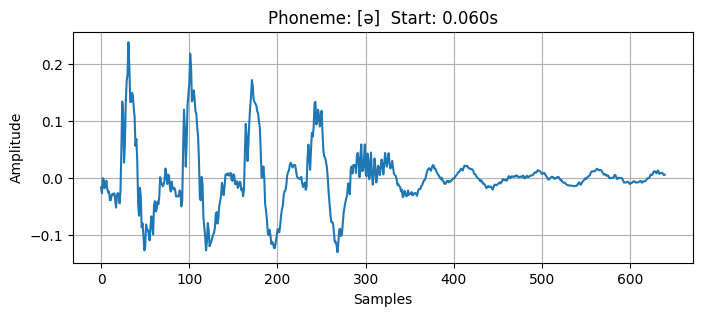

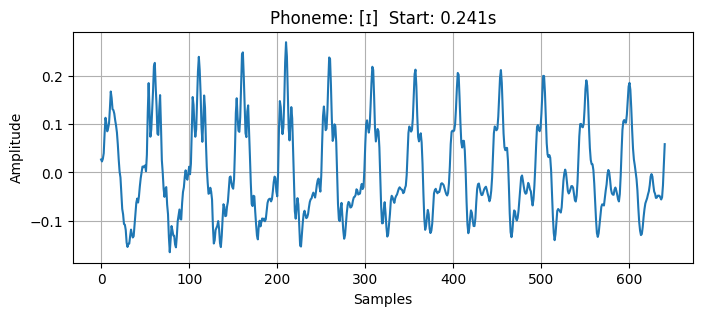

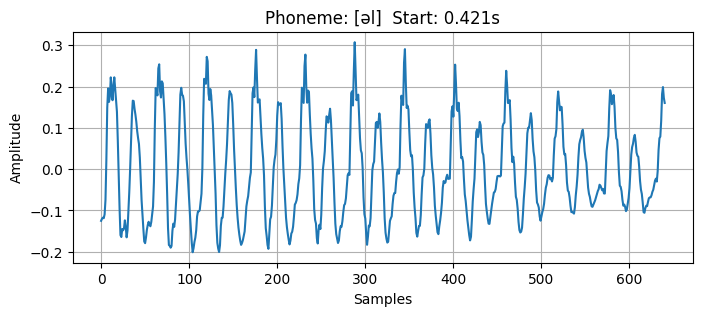

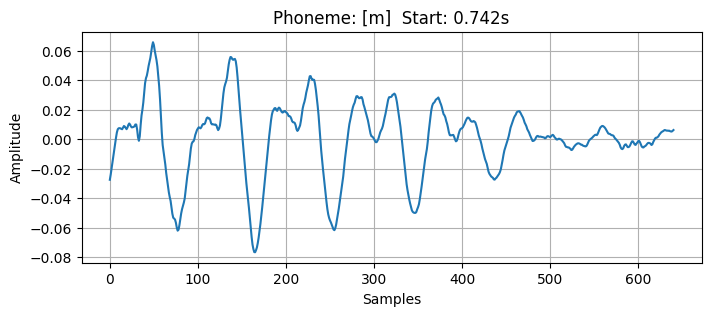

In [1]:
!pip install torch torchaudio librosa transformers phonemizer soundfile
!apt-get update
!apt-get install -y espeak-ng

import torch
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

audio_path = "LJ050-0275.wav"
speech_array, sampling_rate = librosa.load(audio_path, sr=16000, mono=True)

model_id = "facebook/wav2vec2-lv-60-espeak-cv-ft"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)
model.eval()

inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)[0]
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids.tolist())

num_frames = logits.shape[1]
audio_duration = len(speech_array) / 16000
time_per_frame = audio_duration / num_frames

phoneme_list = []
prev_token = None

for i, t in enumerate(tokens):
    if t not in [processor.tokenizer.pad_token, "|"] and t != prev_token:
        phoneme_list.append({
            "char": t,
            "start": i * time_per_frame,
            "end": (i + 1) * time_per_frame
        })
    prev_token = t

print("Recognized Phonemes:")
print(" ".join([p["char"] for p in phoneme_list]))

def extract_and_plot(index):
    p = phoneme_list[index]
    start_sample = int(p["start"] * 16000)
    end_sample = int(p["end"] * 16000) + int(0.02 * 16000)
    segment = speech_array[start_sample:end_sample]

    filename = f"phoneme_{index}_{p['char']}.wav"
    sf.write(filename, segment, 16000)

    plt.figure(figsize=(8, 3))
    plt.plot(segment)
    plt.title(f"Phoneme: [{p['char']}]  Start: {p['start']:.3f}s")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

if len(phoneme_list) > 10:
    extract_and_plot(1)
    extract_and_plot(3)
    extract_and_plot(6)
    extract_and_plot(10)


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak-ng is already the newest version (1.50+dfsg-10ubuntu0.1).
0 upgraded, 0 newly installed

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

Recognized Phonemes:
m ə t ɪ ɹ j əl l i ɪ m p ɹ uː v ɐ p ɑː n ð ə p ɹ ə s iː dʒ ɚ z ɪ n ə f ɛ k t æ t ð ə t aɪ m ʌ v p ɹ ɛ z ᵻ d ə n t k ɛ n ᵻ d i z ɐ s æ s ɪ n eɪ ʃ ə n æ n d ɹ ᵻ z ʌ l t ɪ n ɐ s ə b s t æ n ʃ əl l ɛ s ə n ɪ ŋ ʌ v ð ə d eɪ n dʒ ɚ


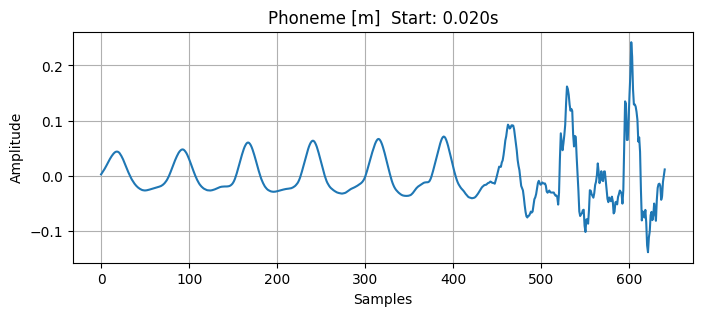

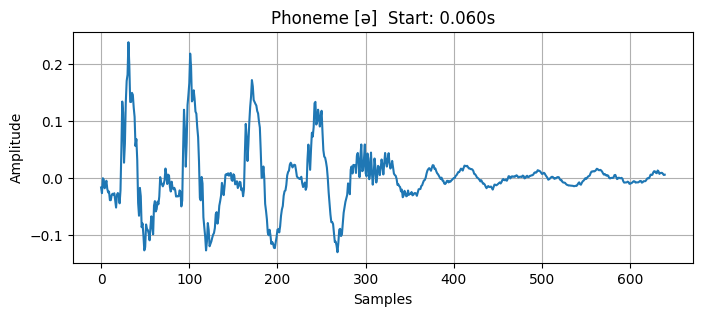

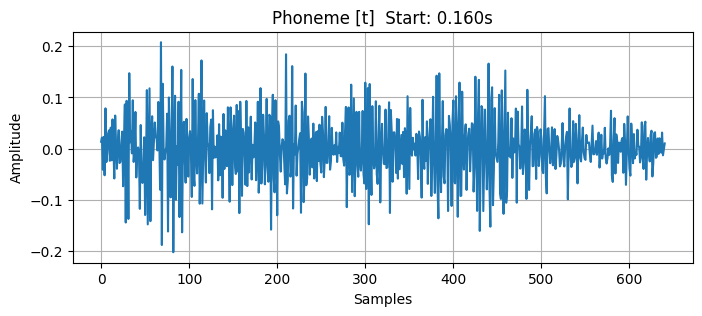

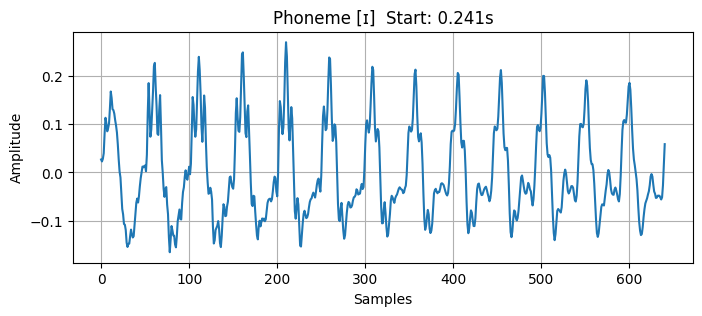

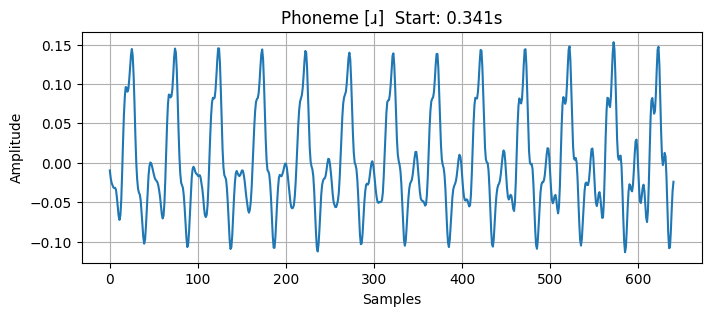

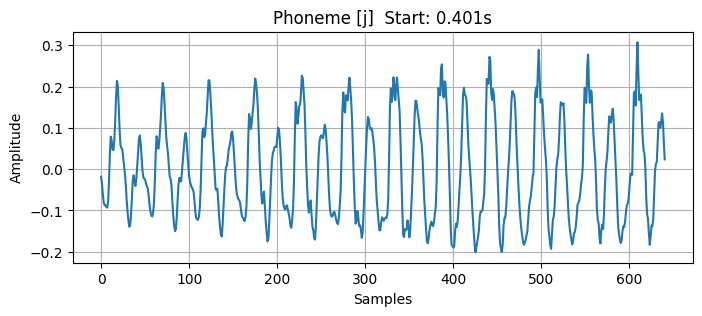

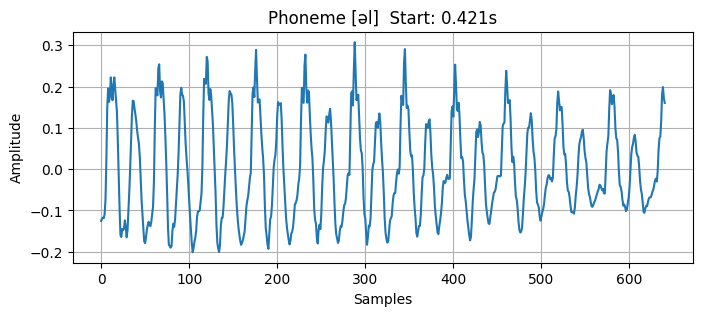

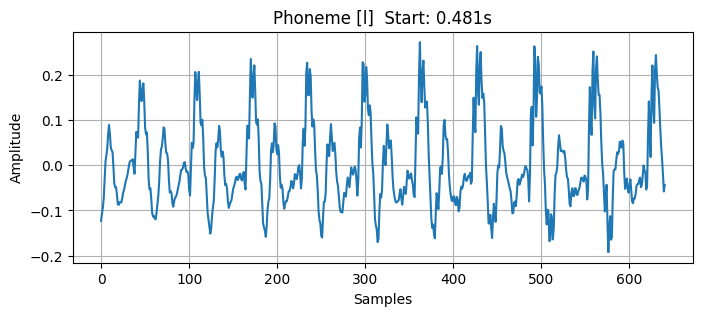

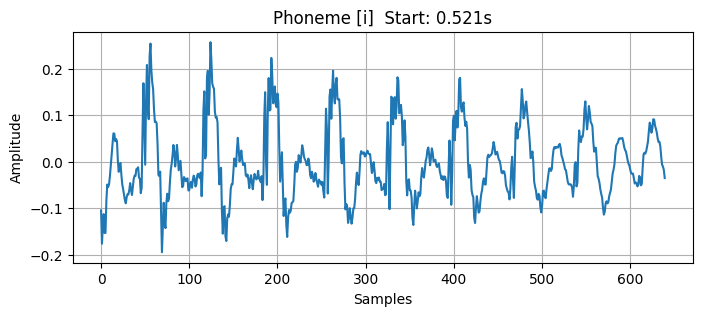

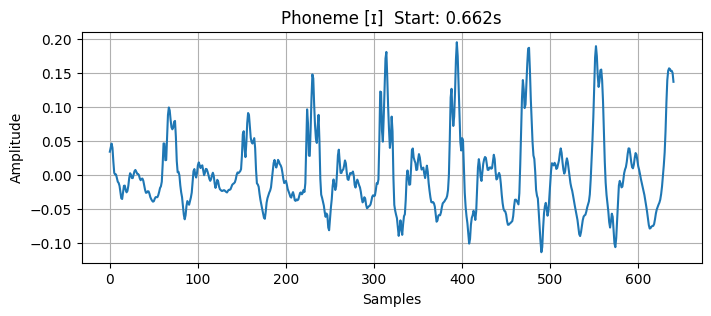

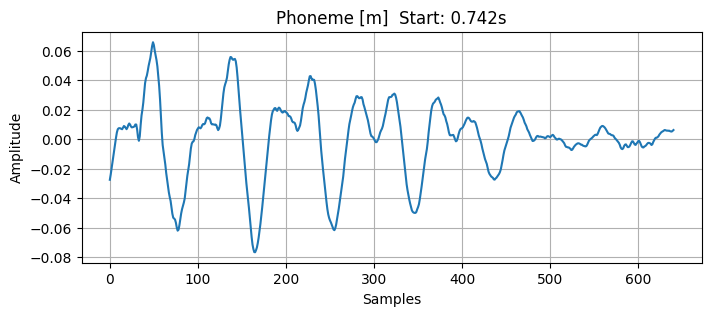

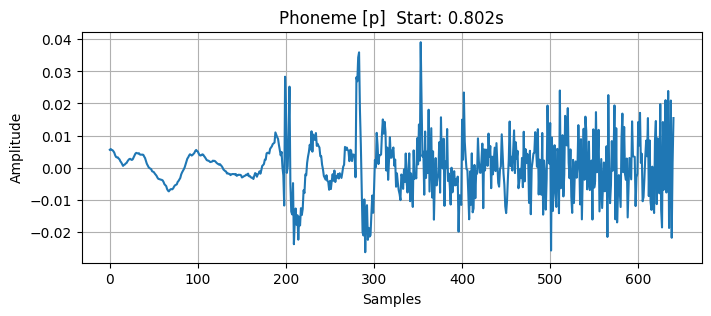

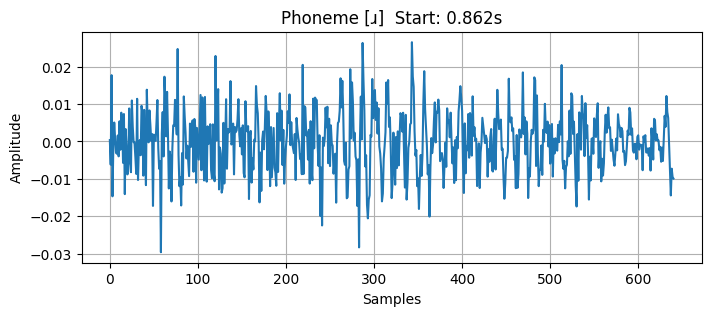

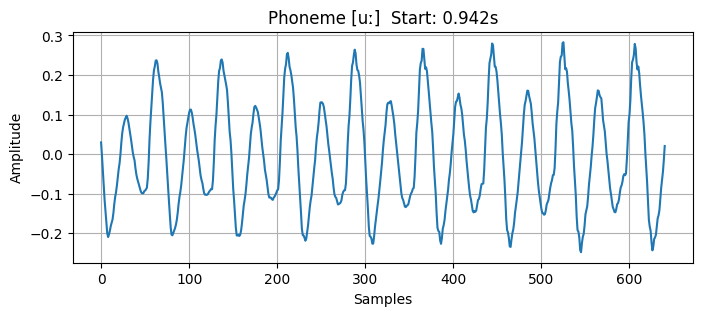

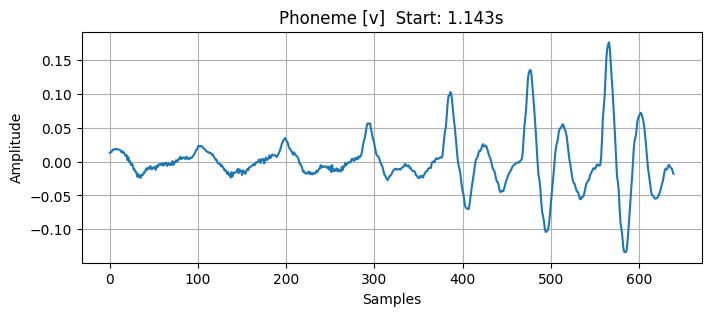

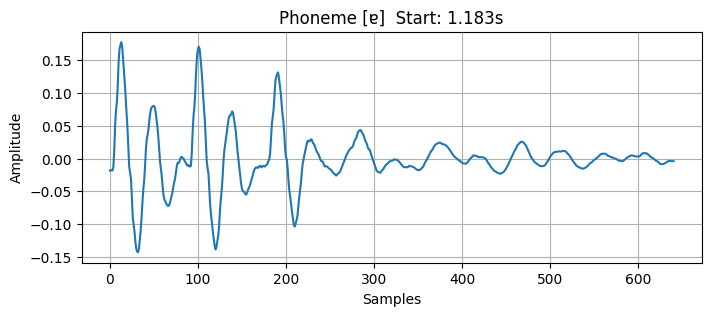

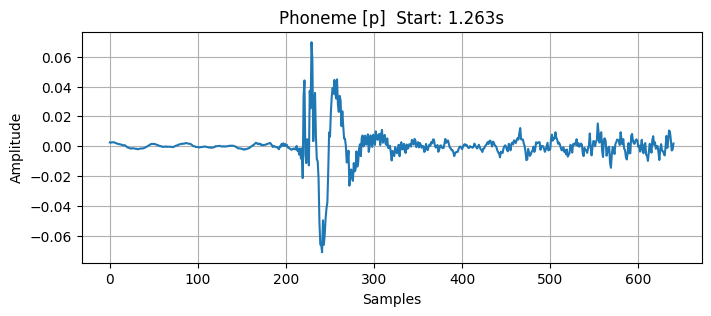

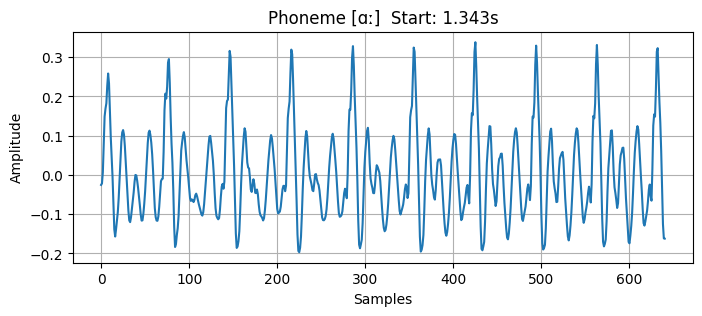

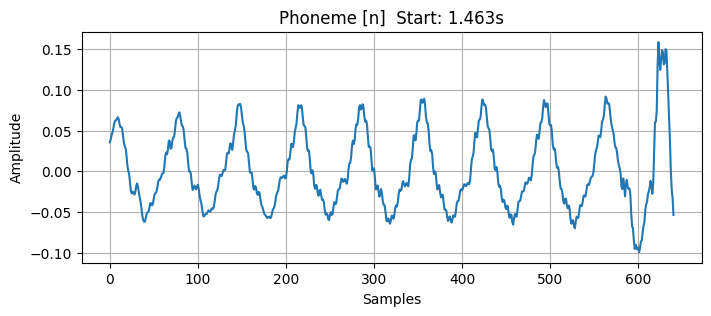

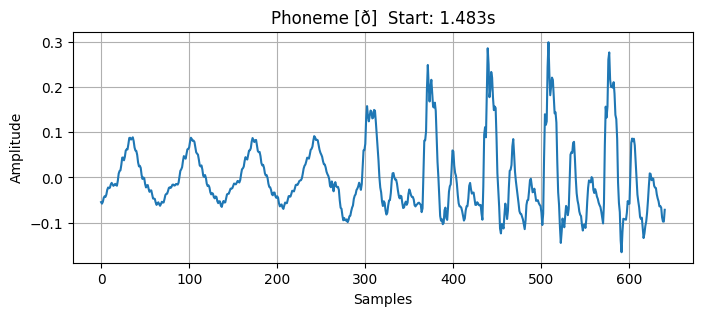

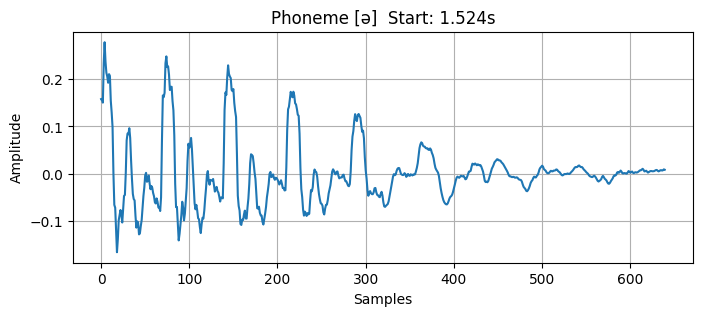

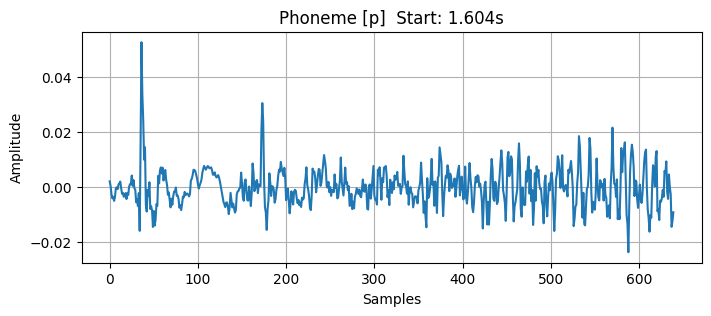

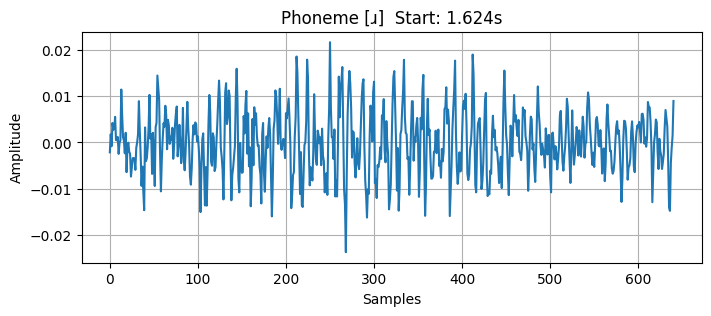

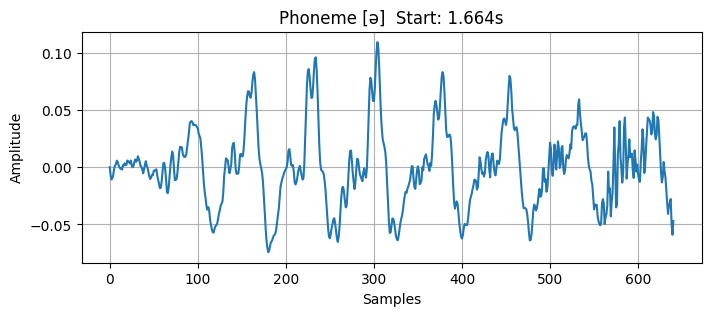

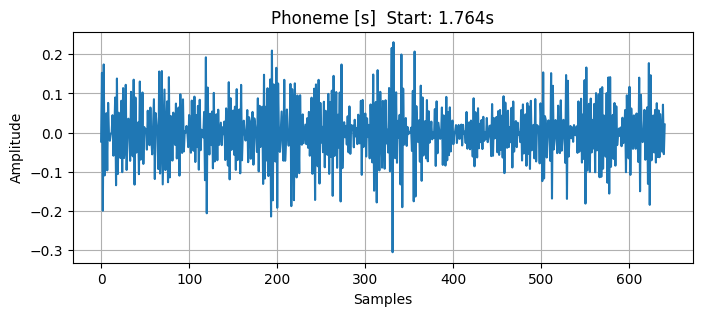

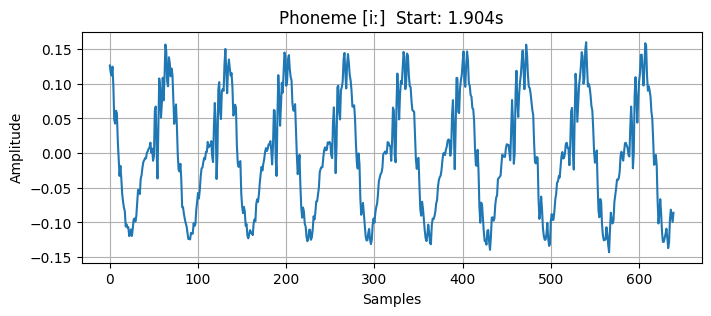

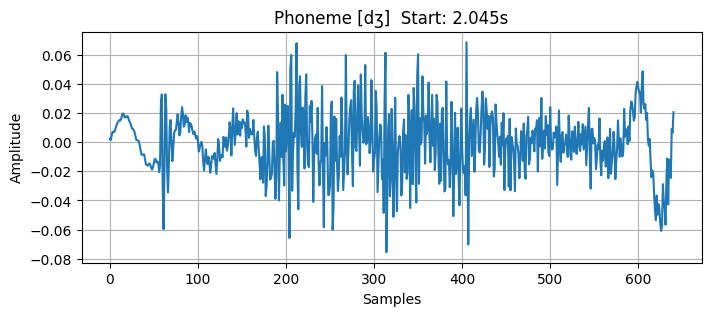

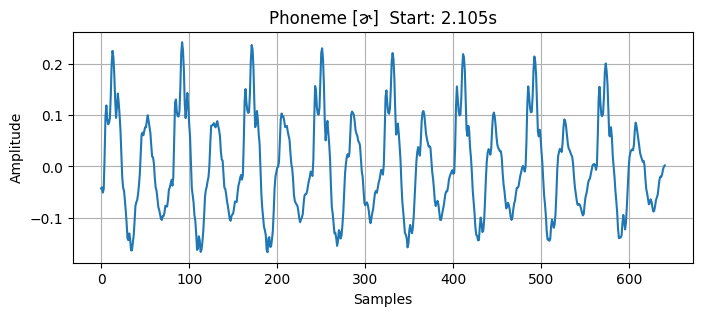

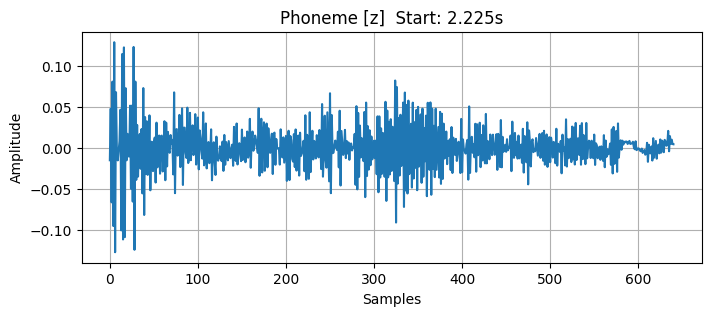

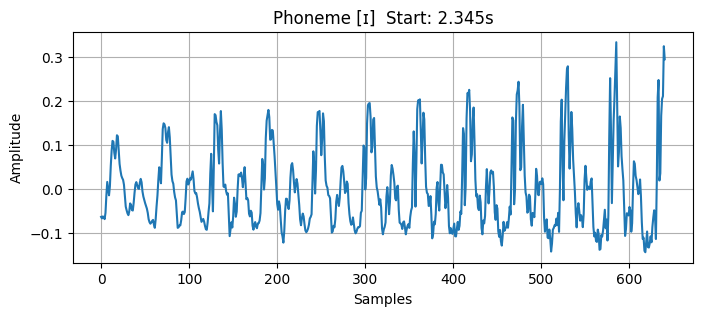

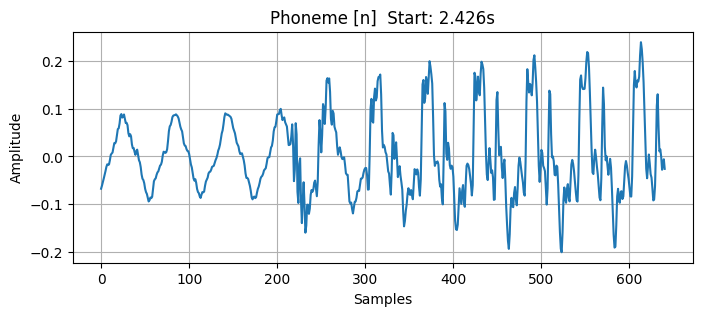

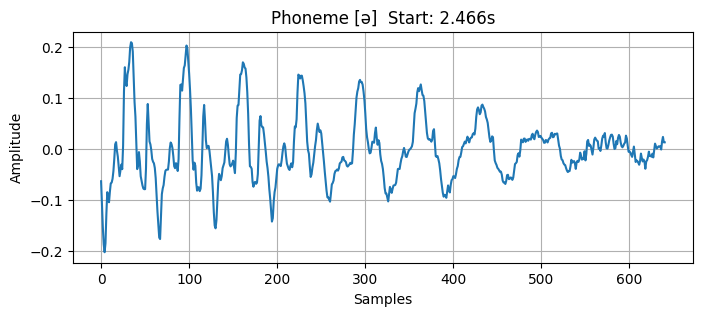

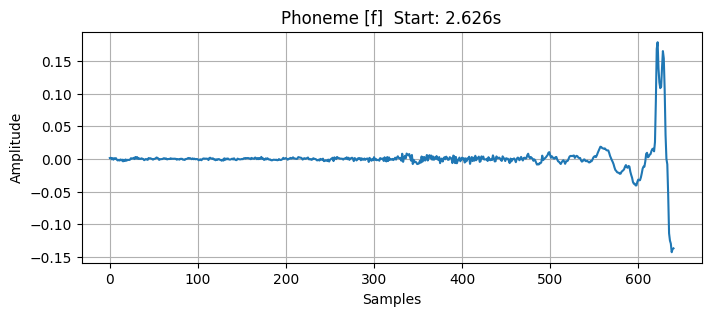

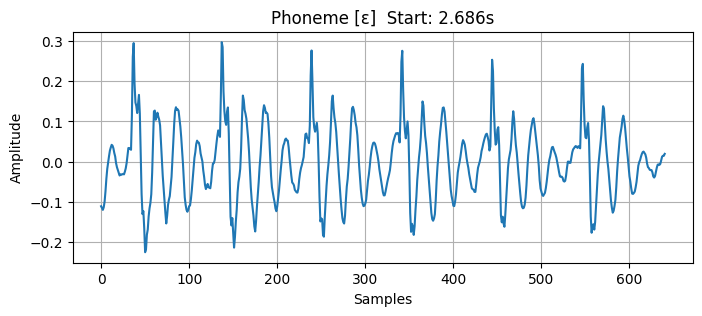

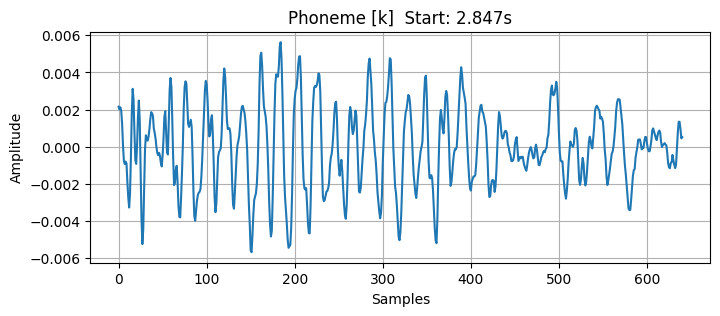

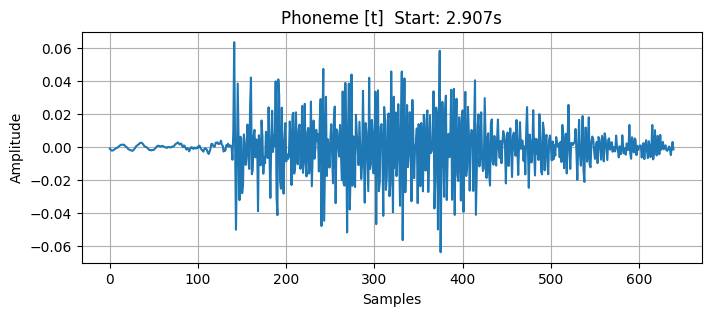

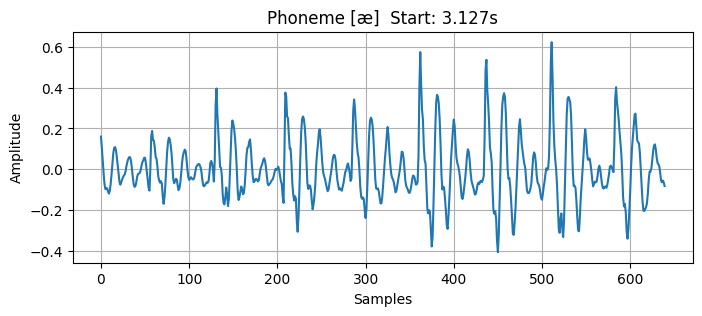

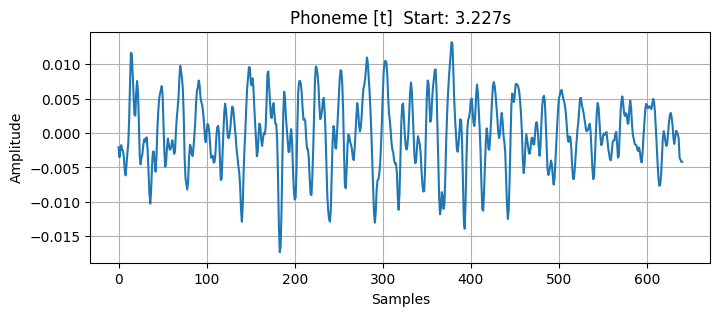

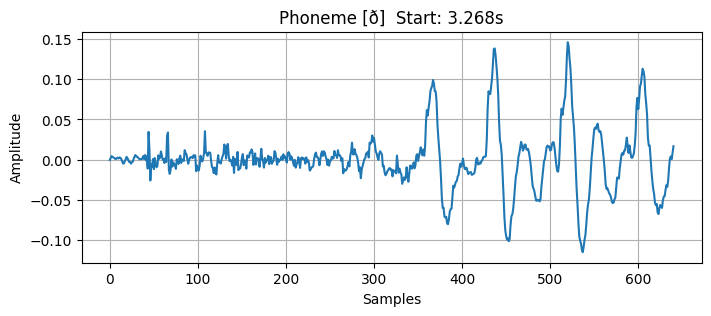

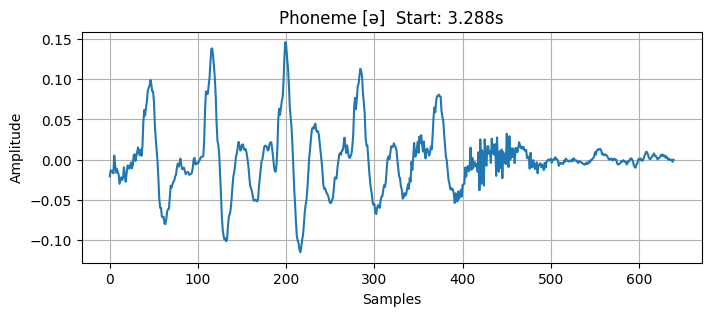

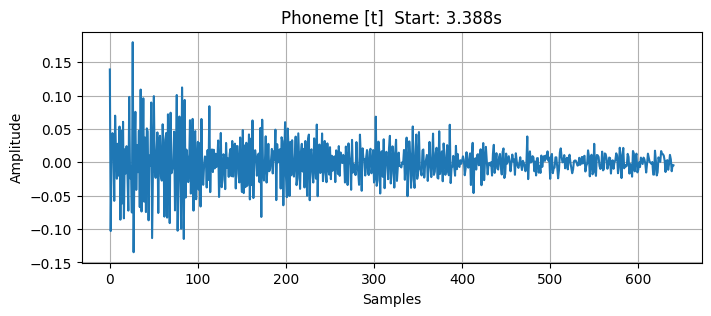

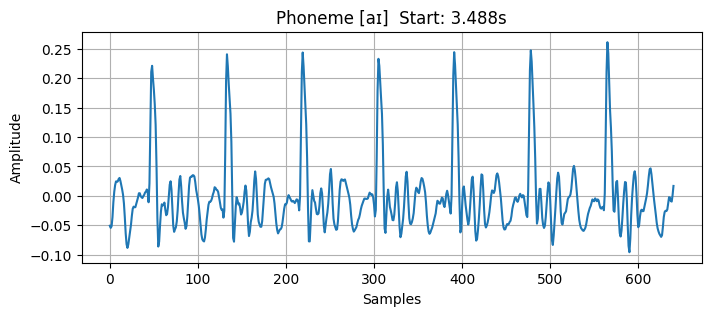

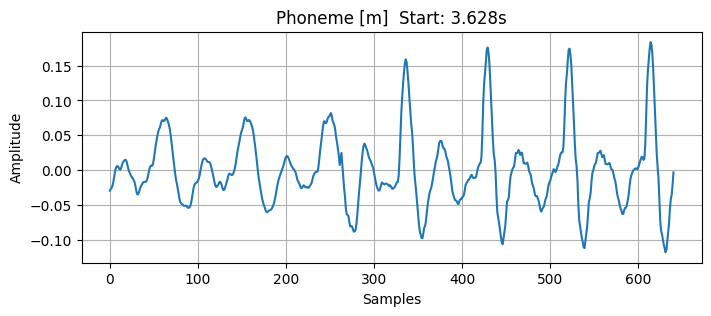

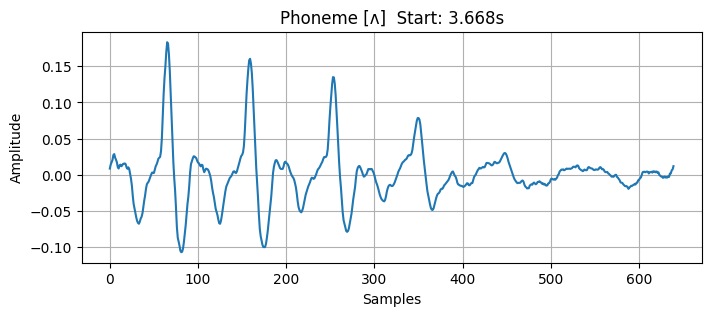

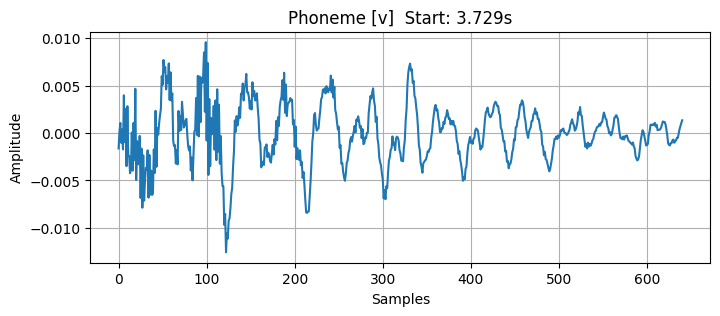

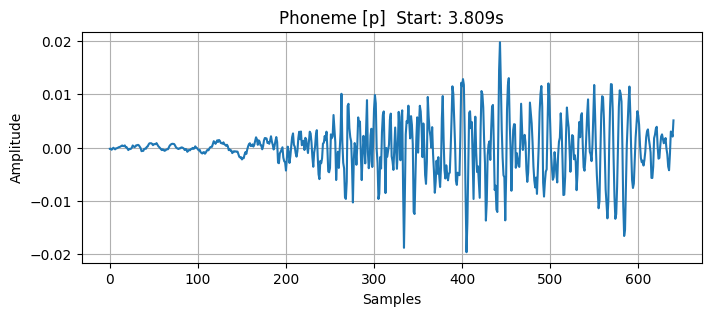

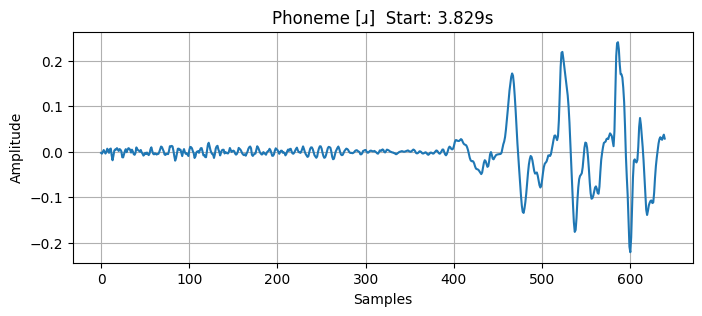

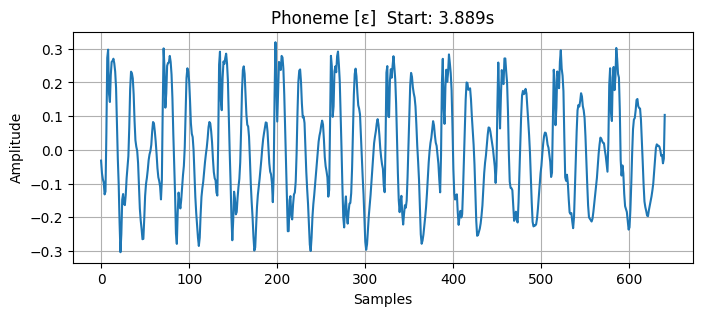

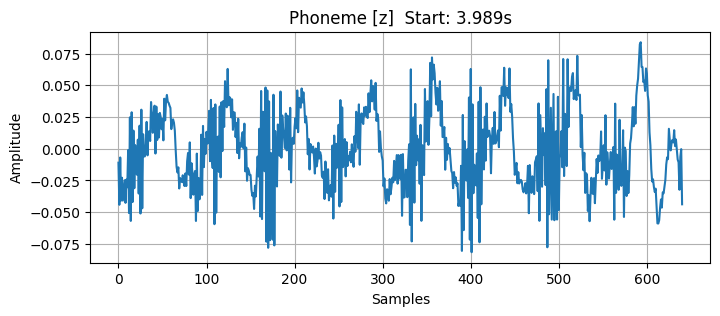

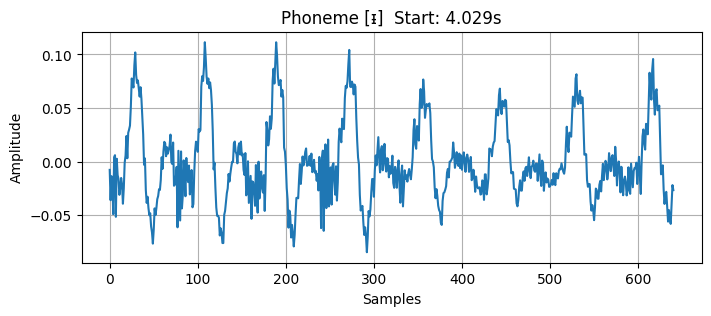

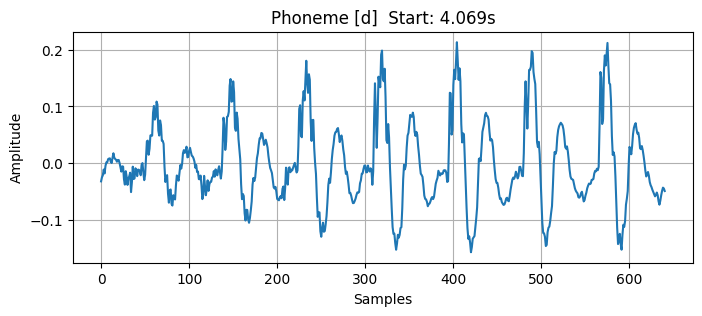

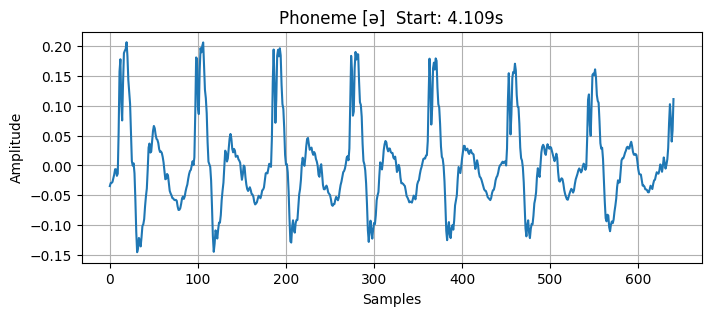

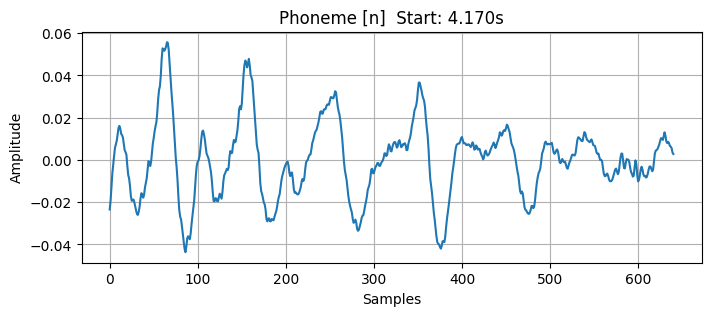

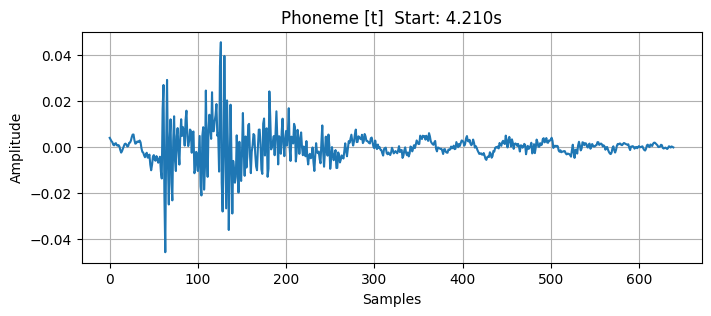

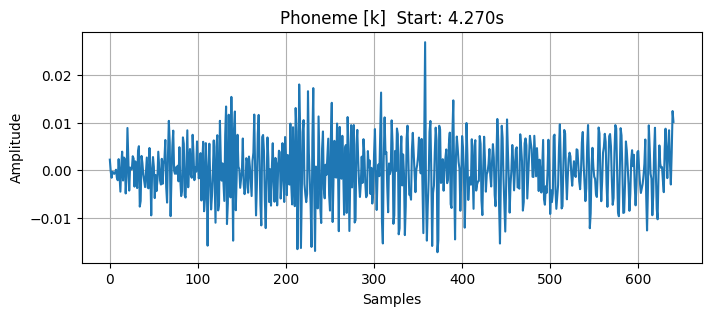

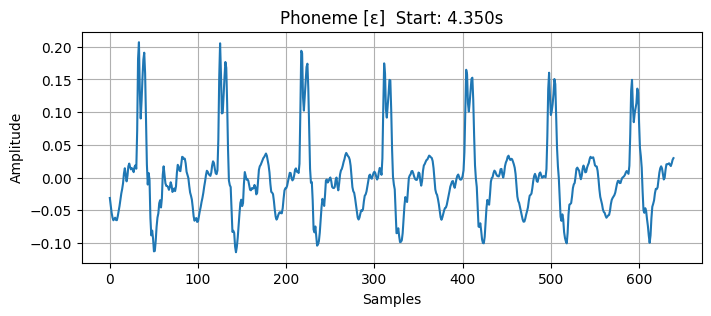

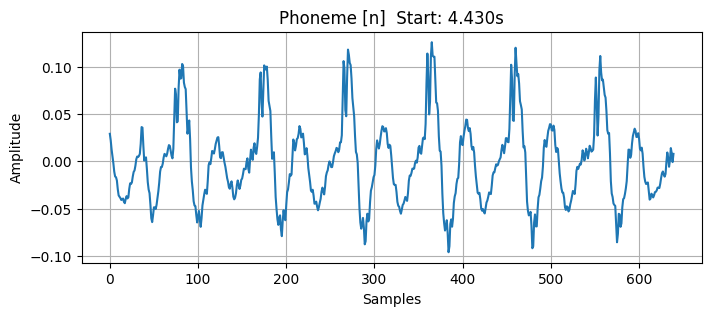

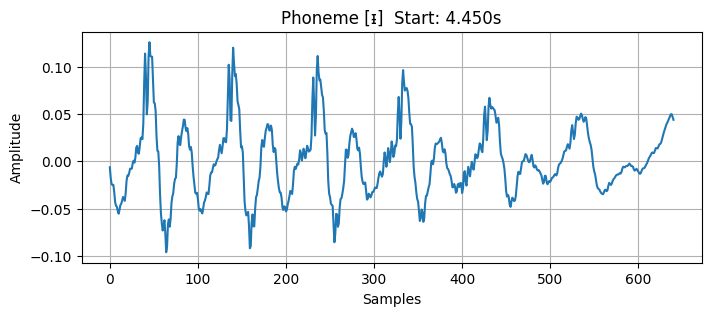

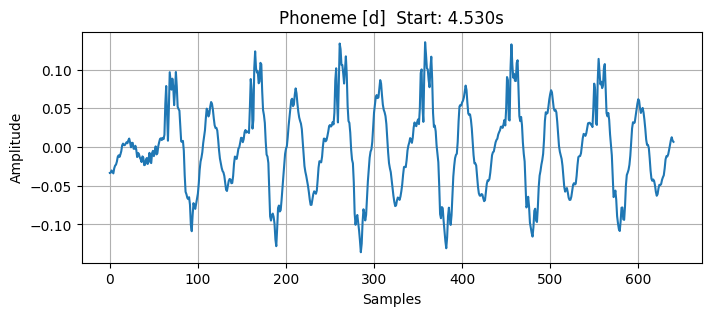

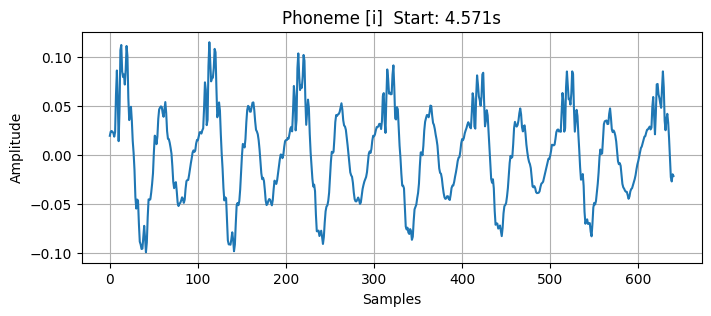

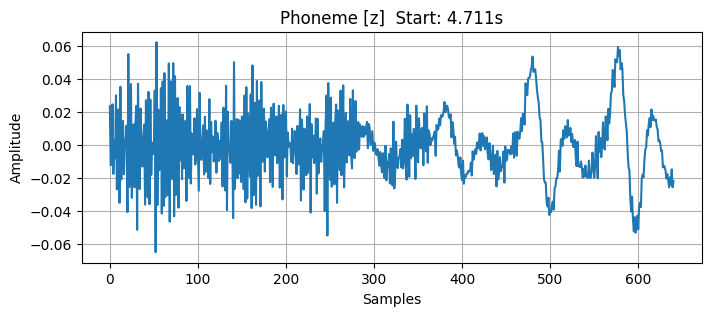

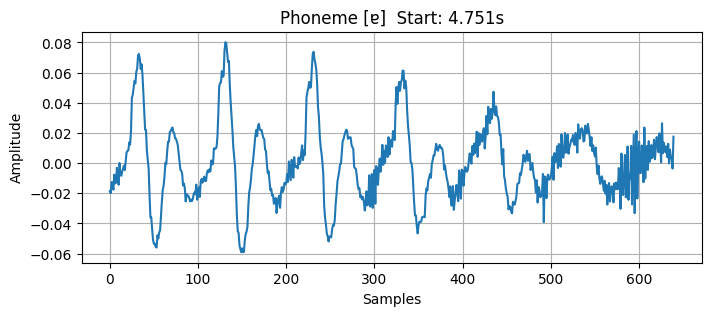

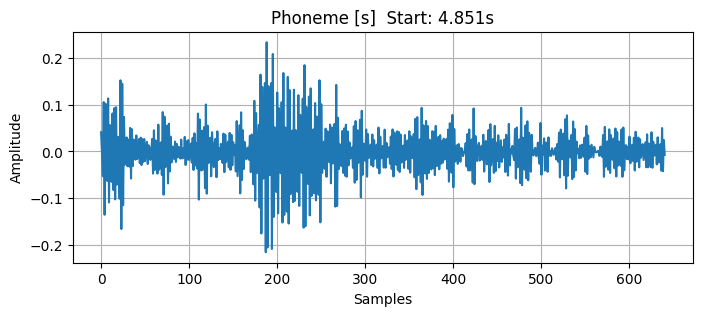

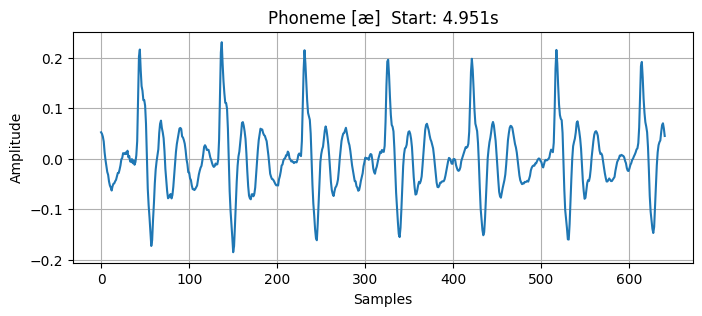

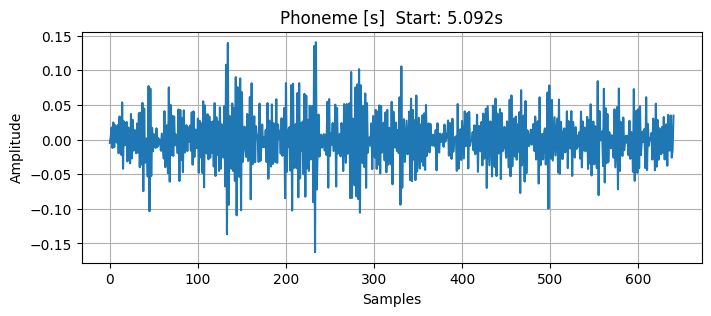

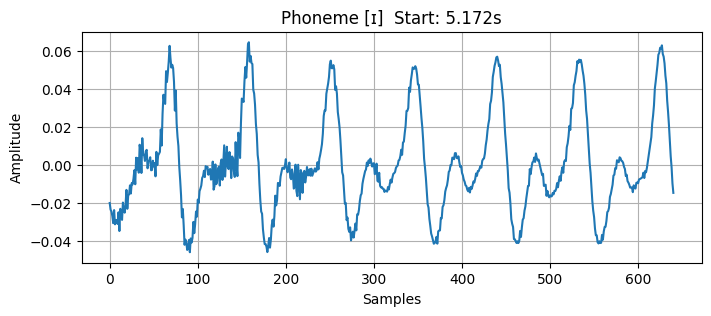

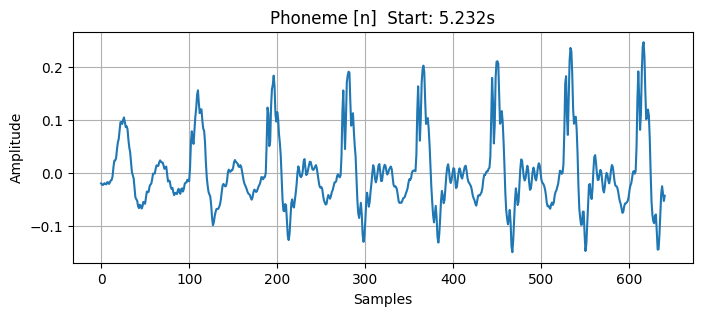

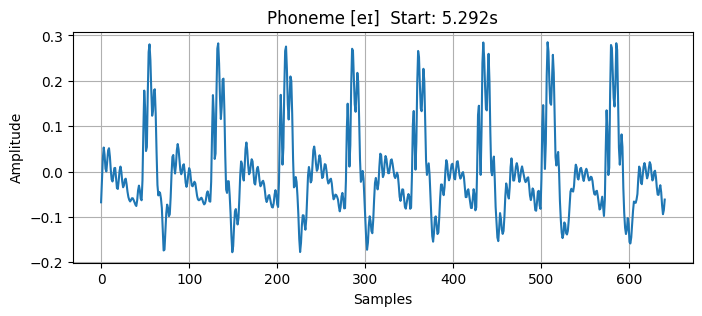

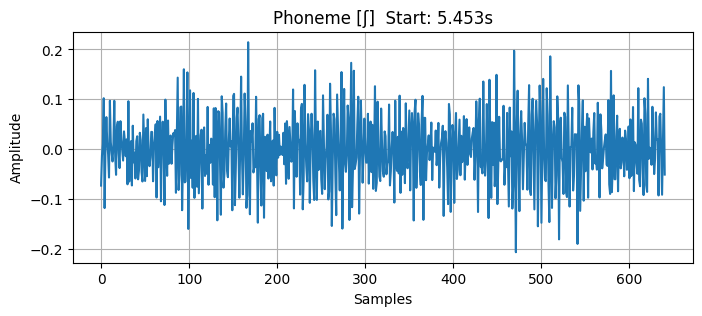

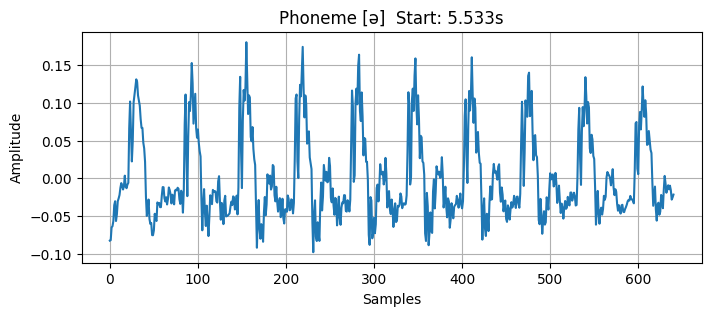

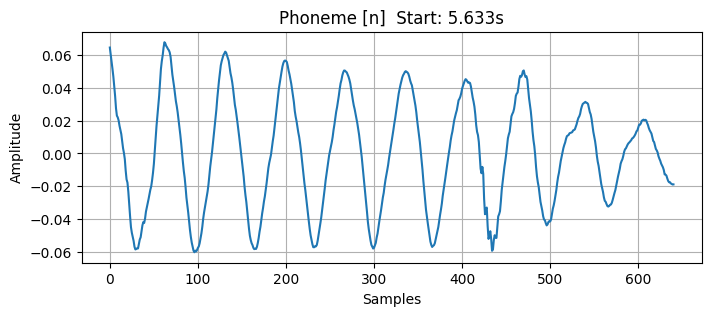

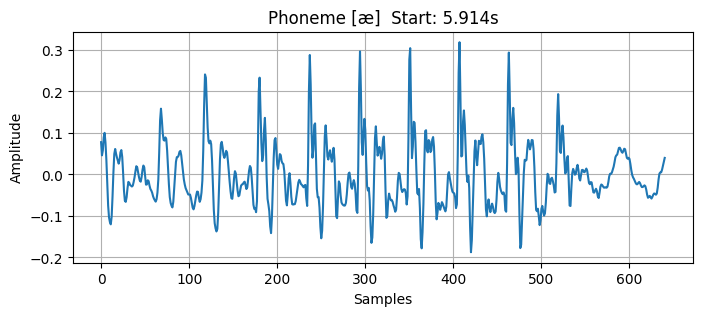

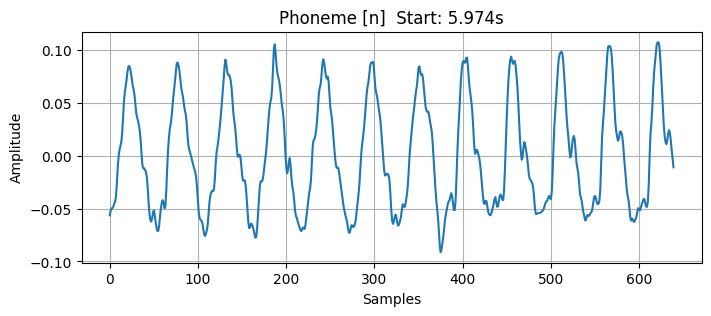

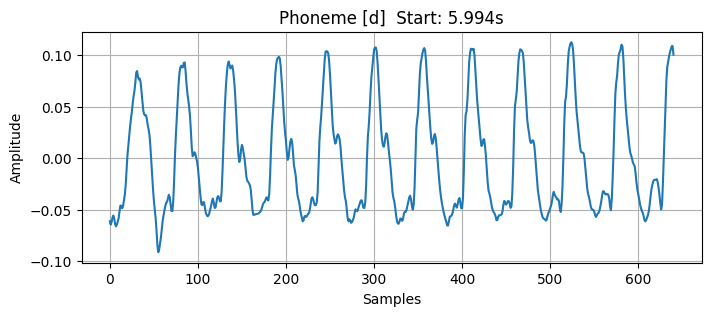

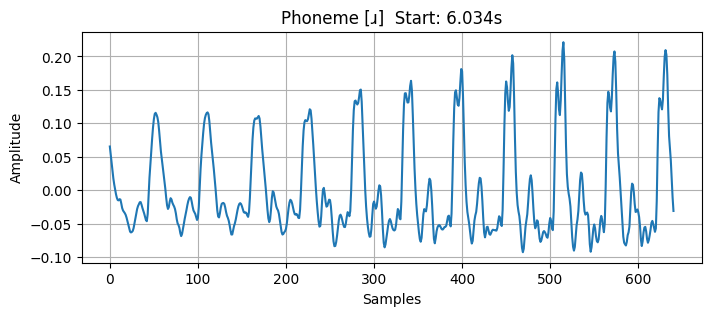

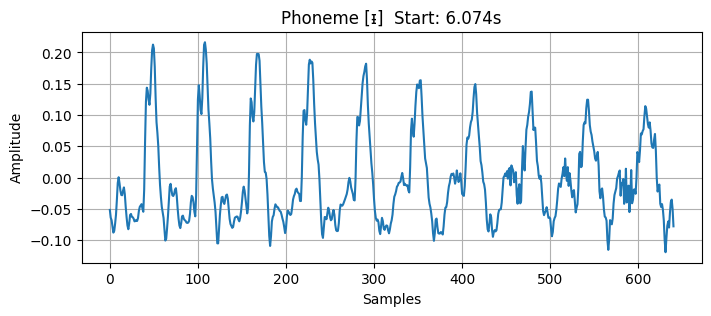

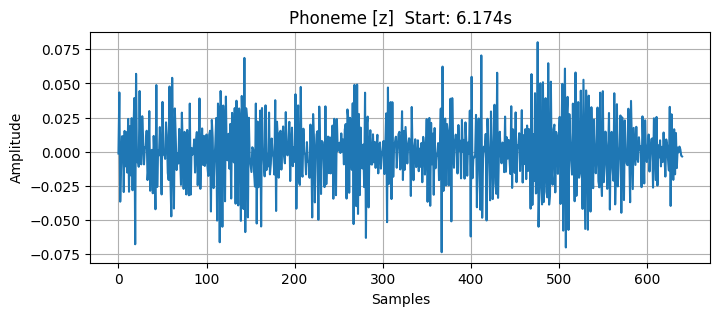

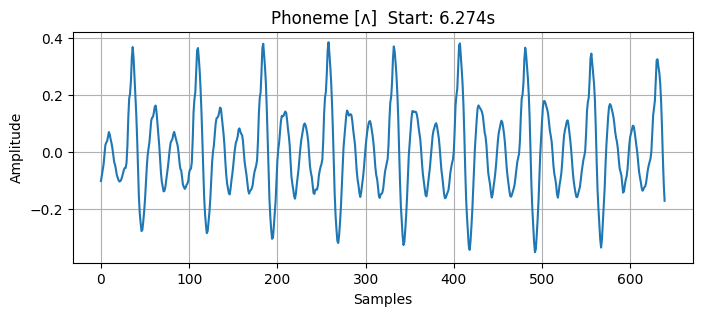

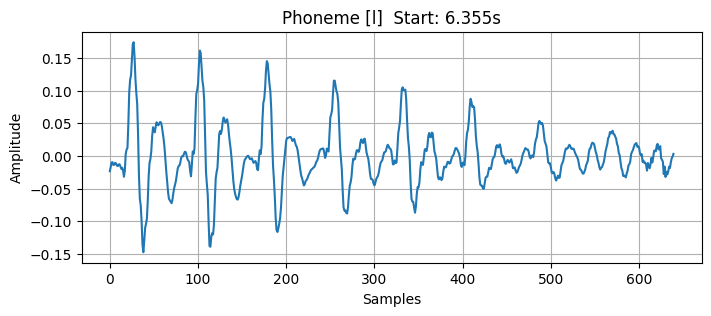

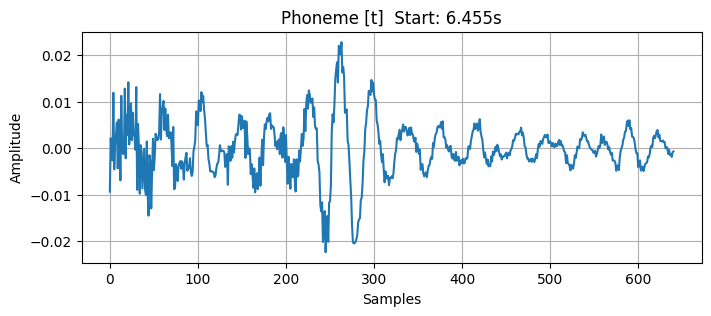

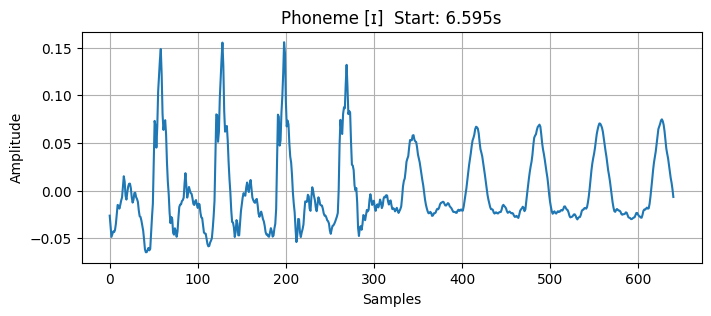

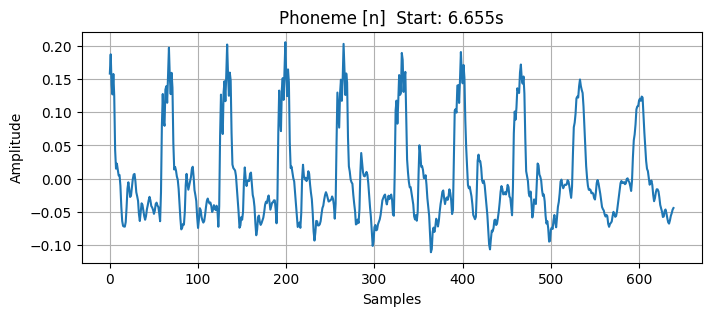

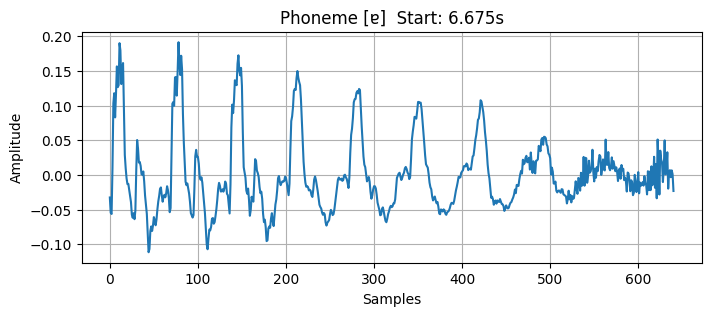

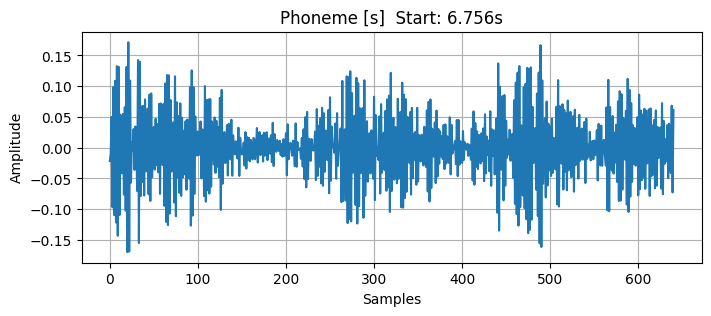

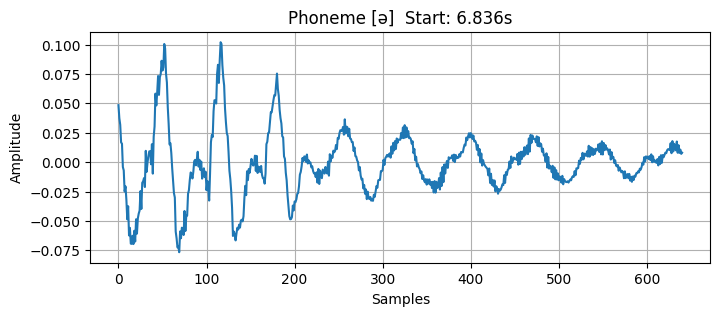

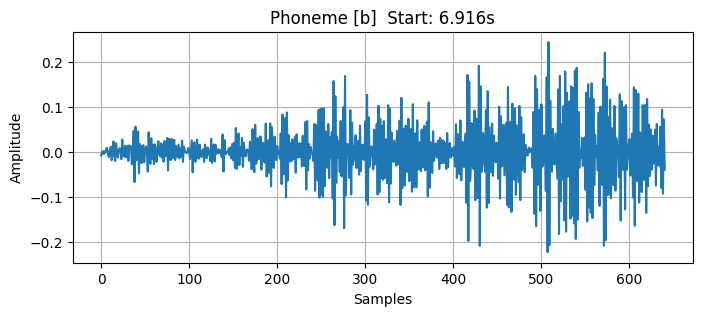

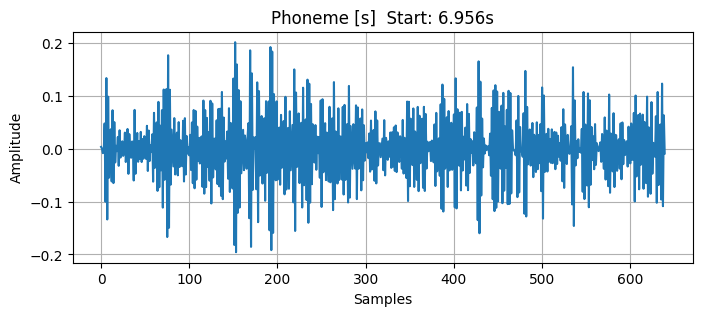

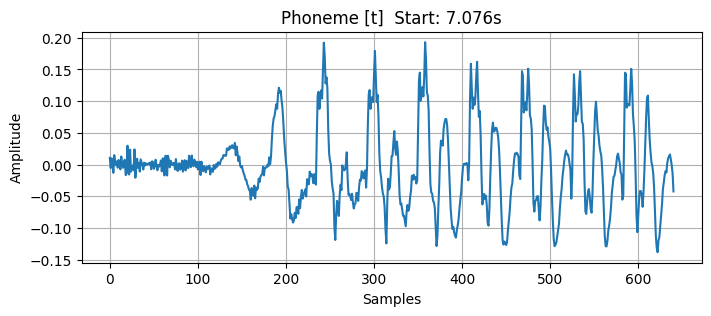

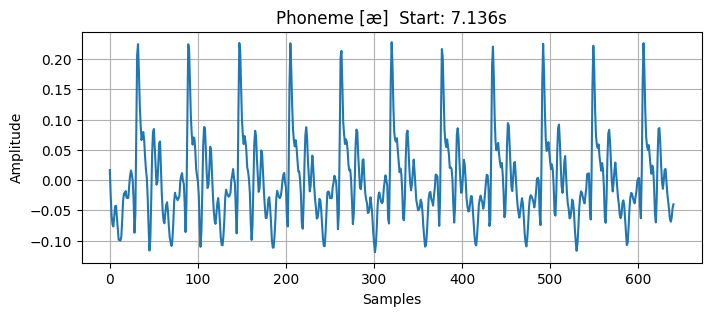

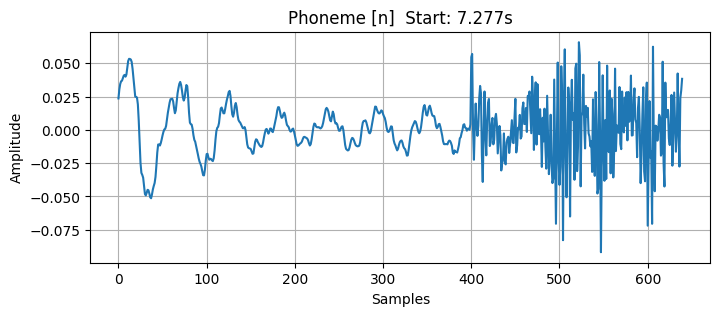

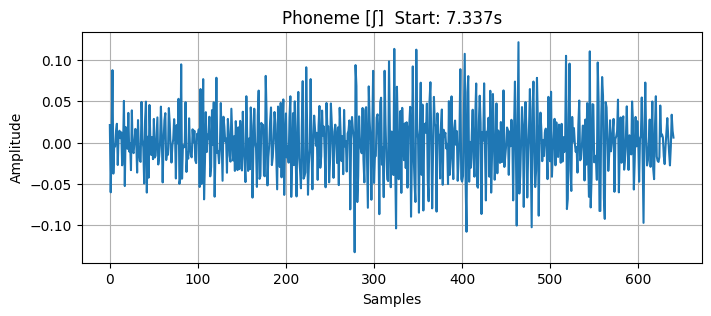

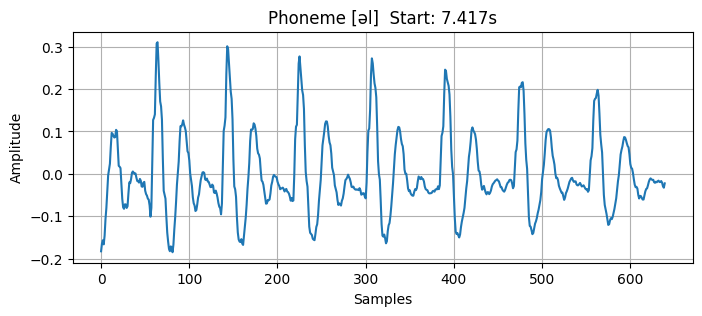

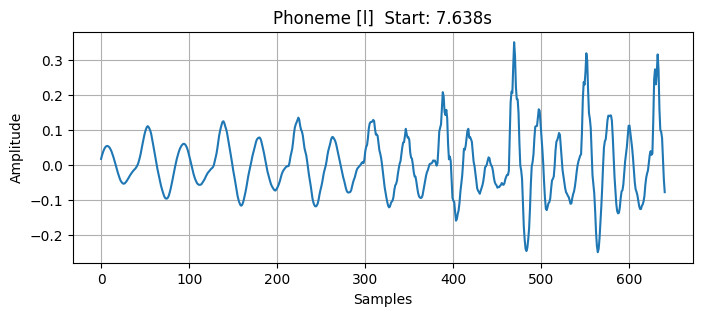

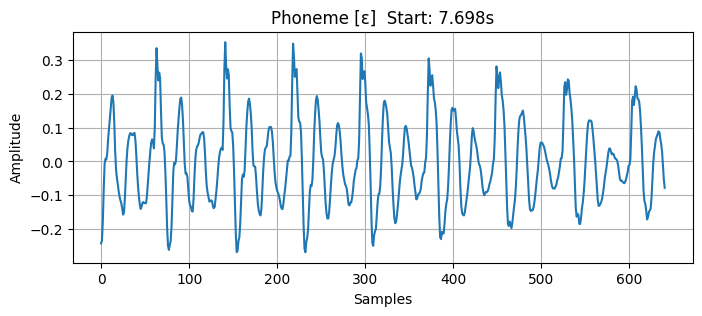

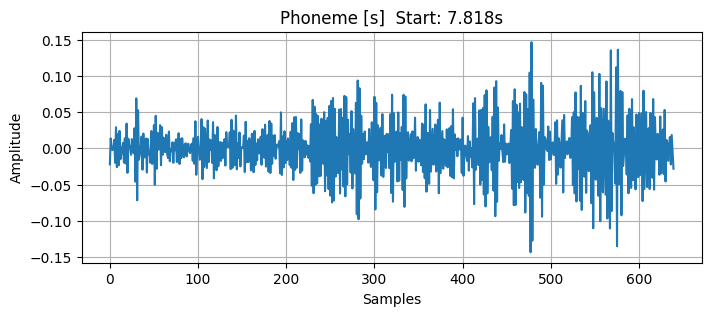

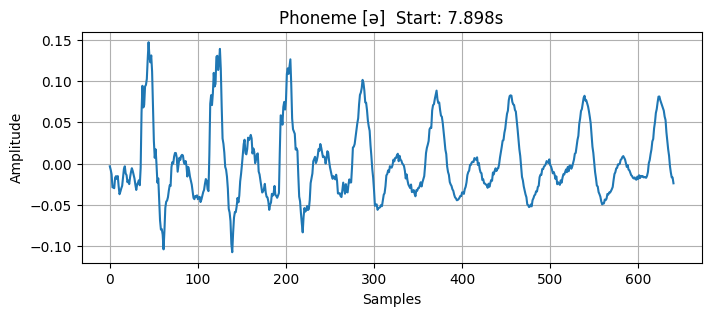

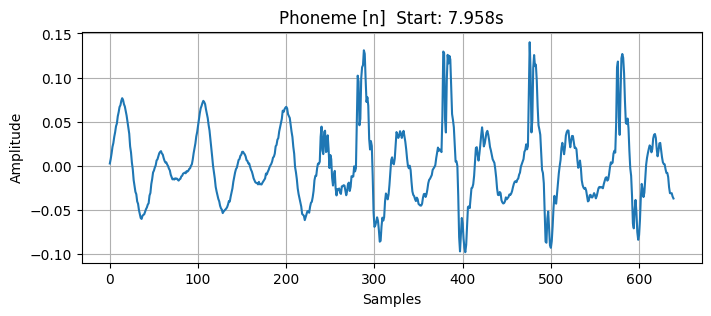

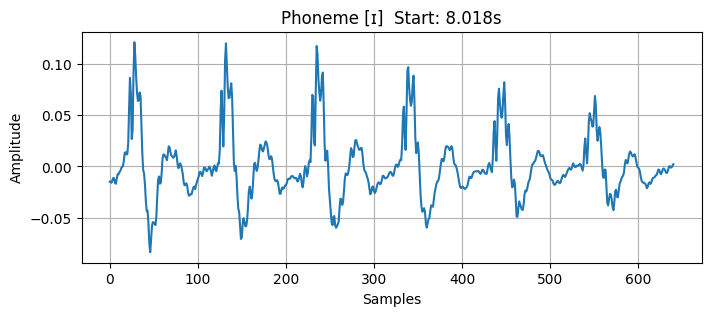

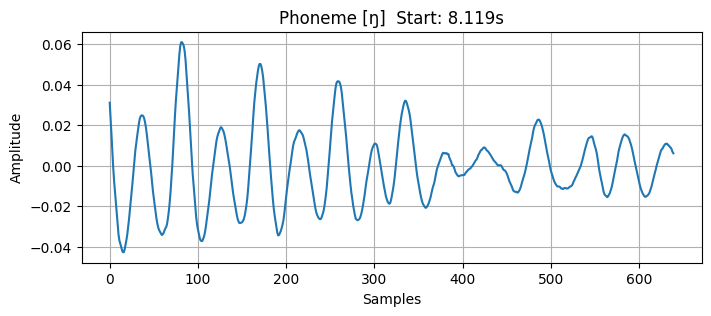

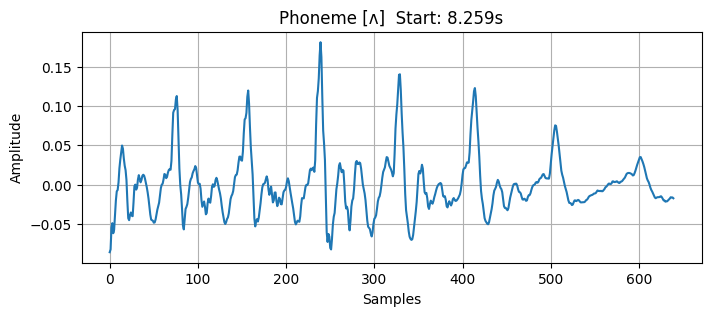

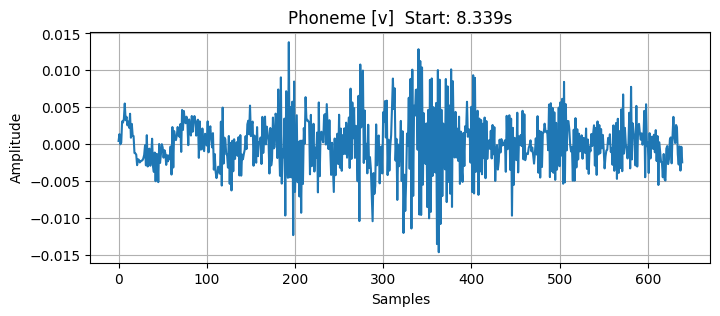

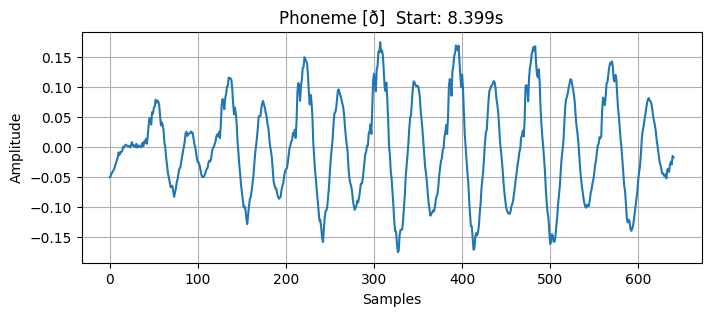

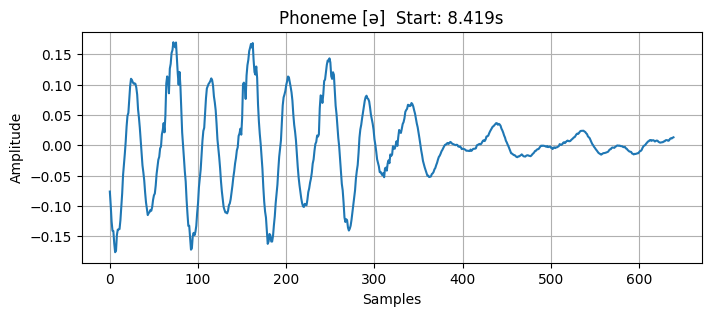

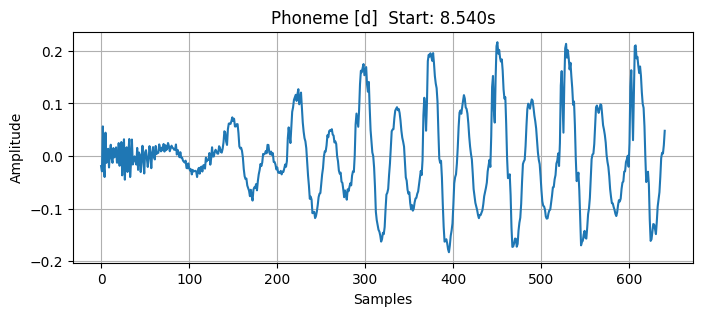

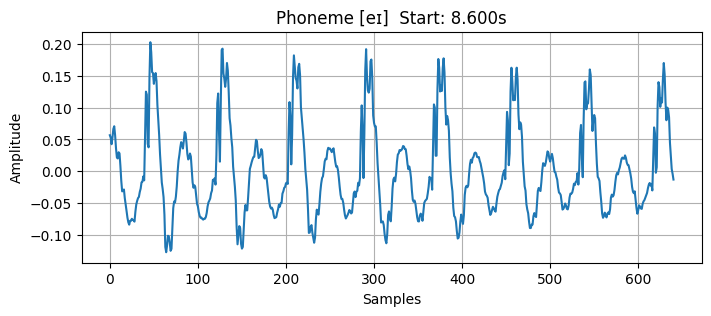

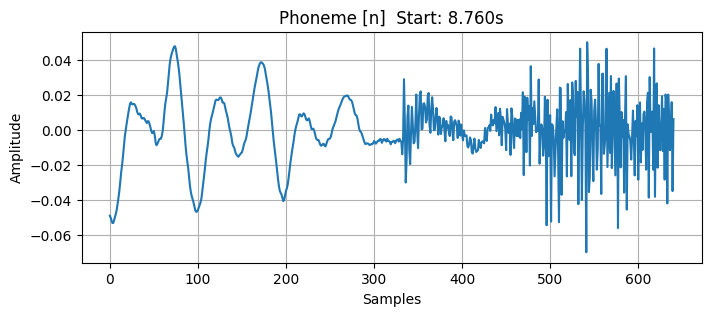

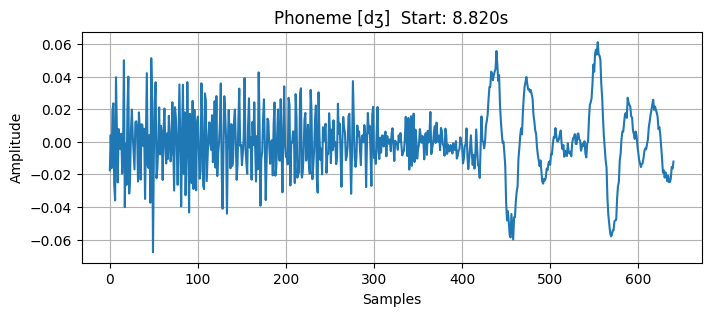

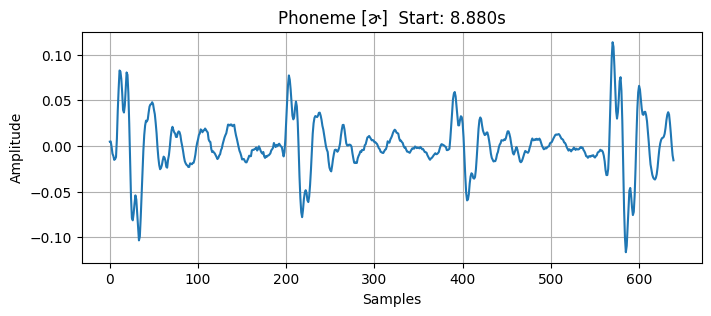

In [2]:
!pip install torch torchaudio librosa transformers phonemizer soundfile
!apt-get update
!apt-get install -y espeak-ng

import torch
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

audio_path = "LJ050-0275.wav"
speech_array, sampling_rate = librosa.load(audio_path, sr=16000, mono=True)

model_id = "facebook/wav2vec2-lv-60-espeak-cv-ft"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)
model.eval()

inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)[0]
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids.tolist())

num_frames = logits.shape[1]
audio_duration = len(speech_array) / 16000
time_per_frame = audio_duration / num_frames

phoneme_list = []
prev_token = None

for i, t in enumerate(tokens):
    if t not in [processor.tokenizer.pad_token, "|"] and t != prev_token:
        phoneme_list.append({
            "char": t,
            "start": i * time_per_frame,
            "end": (i + 1) * time_per_frame
        })
    prev_token = t

print("Recognized Phonemes:")
print(" ".join([p["char"] for p in phoneme_list]))

for idx, p in enumerate(phoneme_list):
    start_sample = int(p["start"] * 16000)
    end_sample = int(p["end"] * 16000) + int(0.02 * 16000)
    segment = speech_array[start_sample:end_sample]

    sf.write(f"phoneme_{idx}_{p['char']}.wav", segment, 16000)

    plt.figure(figsize=(8, 3))
    plt.plot(segment)
    plt.title(f"Phoneme [{p['char']}]  Start: {p['start']:.3f}s")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
